# Using PauliPropagation.jl from Python

This notebook shows how to use the Julia package PauliPropagation.jl from Python. If you're more comfortable with Python but want to use this Julia package for quantum simulations, this approach works pretty well.

## What's this JuliaCall thing?

JuliaCall is just a Python package that lets you call Julia code from Python. It's pretty handy because:

- You can use Julia's fast code without leaving Python
- You can call Julia functions almost like they're Python functions
- It handles converting data between the languages for you (often automatically!)

This is great because you can keep working in Python but still use the special features of PauliPropagation.jl when you need them.

## Setting Up

First we need to load juliacall and set up the connection to Julia.

When running this for the first time, it might take a while as Julia gets set up.

In [2]:
# Install juliacall if you haven't already
# Uncomment and run this cell if you need to install the package
#!pip install juliacall

# We'll also need numpy and matplotlib for our Python data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

## Setting Up the Python-Julia Bridge

To use Julia from Python, we first need to import and initialize the `juliacall` library. This will:

1. Start a Julia process in the background
2. Give us access to Julia's functionality through the `Main` object
3. Allow us to execute Julia code directly from Python

When using `juliacall` for the first time on a system, it might take a few minutes to set up the Julia environment.

In [5]:
# This part can be annoying the first time - be patient!
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

print("Installing PauliPropagation.jl (grab a coffee, this could take a minute)...")
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add("PauliPropagation")
    end
""")

jl.seval("using PauliPropagation")
print("Finally! PauliPropagation.jl is loaded")

Julia version: 1.10.9
Installing PauliPropagation.jl (grab a coffee, this could take a minute)...
Finally! PauliPropagation.jl is loaded


## A Note on `juliacall` Installation and Environments

When you `pip install juliacall`, it's installed into your current Python environment. This is the environment that your Jupyter kernel is likely running in.

`juliacall` then manages its own Julia environment. By default, it will install a suitable version of Julia if one is not found, or you can configure it to use an existing Julia installation. Julia packages required by `juliacall` or by the Julia code you run (like `PauliPropagation.jl` here) are typically installed within this `juliacall`-managed Julia environment.

So, while `juliacall` (the Python package) lives in your Python kernel's environment, the Julia operations themselves run in a separate Julia process and environment orchestrated by `juliacall`.

**About Jupyter kernels:** If you want to use juliacall in an existing Jupyter kernel, just install the juliacall package into that kernel's Python environment with `pip install juliacall`. There's no need to create a separate kernel - juliacall will use the Julia instance it manages from your current Python process.

## Making Julia Functions More Pythonic

One of the great things about `juliacall` is that it handles many data conversions automatically, making Julia functions feel quite Pythonic out of the box.

For example:
- Python lists of tuples can often be passed directly where Julia expects a vector of tuples (e.g., for topologies).
- NumPy arrays are automatically converted to Julia arrays when passed to Julia functions.
- Julia numbers (like `Int` or `Float64`) are usually converted to Python `int` or `float` automatically upon return.
- Python's built-in `len()` function can often be used on Julia collection objects, and `juliacall` translates it to Julia's `length()`.

We'll still create a shorter alias for `PauliPropagation` for convenience.

In [4]:
pp = jl.PauliPropagation

Xsym = jl.Symbol("X")  # For X Pauli
Ysym = jl.Symbol("Y")  # For Y Pauli
Zsym = jl.Symbol("Z")  # For Z Pauli

## Understanding Pauli Strings and Operators

Let's go over some of the core concepts from PauliPropagation.jl that we'll be using.

The main data types we'll work with are PauliString and PauliSum. A PauliString is just a tensor product of Pauli operators $X$, $Y$, $Z$, and $I$ with a coefficient, like:

$0.5 \cdot X_1 \otimes Y_2 \otimes Z_3 \otimes I_4 \otimes ... \otimes I_{10}$

When you have multiple PauliStrings added together, that's a PauliSum:

$0.5 \cdot X_1 \otimes Z_2 + 1.2 \cdot Y_3 \otimes Y_4 + 0.7 \cdot Z_1 \otimes Z_5$

The quantum circuit is basically a sequence of gates acting on qubits. And the topology defines which qubits can interact with each other (this matters for two-qubit gates).

Let's create a simple Pauli operator and see what we get:

In [6]:
# Let's create a 10-qubit system for our examples
nqubits = 10

# A PauliString representing Z on the 5th qubit (indices are 1-based in Julia)
observable = pp.PauliString(nqubits, Zsym, 5)
print("Single Z observable:", observable)

# We can also create more complex observables
# Format: PauliString(nqubits, [types], [positions], coefficient)
complex_obs = pp.PauliString(nqubits, [Xsym, Ysym, Zsym], [1, 3, 7], 2.5)
print("Complex observable:", complex_obs)

# Converting to a PauliSum (needed for propagation)
pauli_sum_observable = pp.PauliSum(observable)
print("Type of pauli_sum_observable:", type(pauli_sum_observable))
print(f"Length of pauli_sum_observable: {len(pauli_sum_observable)}")

Single Z observable: PauliString(nqubits: 10, 1.0 * IIIIZIIIII)
Complex observable: PauliString(nqubits: 10, 2.5 * XIYIIIZIII)
Type of pauli_sum_observable: <class 'juliacall.AnyValue'>
Length of pauli_sum_observable: 1


## Creating Custom Topologies with Python Lists

A significant advantage of using Python with this Julia package is how easy it is to define custom qubit topologies. A topology is just fancy talk for "which qubits can talk to each other," super important for real quantum hardware where not every qubit connects to every other one.

In PauliPropagation.jl, topologies would normally be defined using Julia's syntax. However, `juliacall` is smart enough to convert Python lists of tuples directly into the format Julia expects for topologies! This means topologies can be defined using pure Python syntax.

Let's create a simple ring of qubits with a few extra long-range connections:

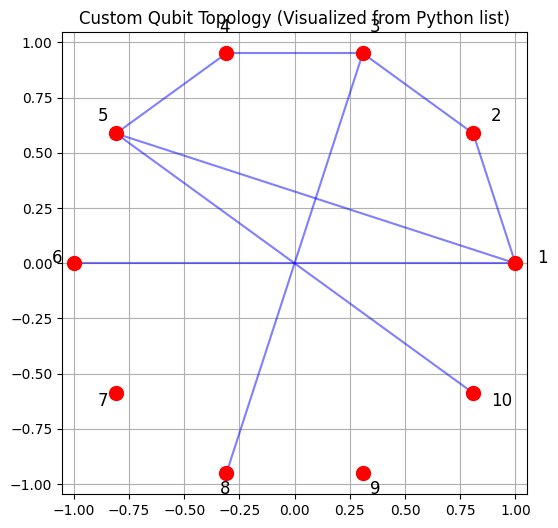

Defined custom topology in Python with 8 connections.
For comparison, the standard brick layer topology (a Julia object) has 10 connections.


In [7]:
# Each tuple represents a connection between two qubits (1-indexed)
custom_connections_py = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1),  # Ring
                         (1, 6), (3, 8), (5, 10)]  # Some long-range connections

# Juliacall will convert this Python list of tuples automatically when passed to a Julia function
# that expects a topology. For example, when creating a circuit:
# circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=custom_connections_py)

# For comparison, let's also create a standard brick layer topology using PauliPropagation.jl
# We can pass the Python list directly here too if the function supports it,
# or use Julia's own construction if needed.
# Here, bricklayertopology itself is a Julia function.
brick_topology_jl = pp.bricklayertopology(nqubits, periodic=True)

plt.figure(figsize=(6, 6))
plt.title("Custom Qubit Topology (Visualized from Python list)")

angles = np.linspace(0, 2*np.pi, nqubits, endpoint=False)
positions = {i+1: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}

for q1, q2 in custom_connections_py:
    x1, y1 = positions[q1]
    x2, y2 = positions[q2]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.5)

for i, (x, y) in positions.items():
    plt.plot(x, y, 'ro', markersize=10)
    plt.text(x*1.1, y*1.1, f"{i}", fontsize=12)

plt.axis('equal')
plt.grid(True)
plt.show()

print(f"Defined custom topology in Python with {len(custom_connections_py)} connections.")
# We can use Python's len() on Julia collections returned by juliacall!
print(f"For comparison, the standard brick layer topology (a Julia object) has {len(brick_topology_jl)} connections.")

## Basic Example: Propagating an Observable Through a Quantum Circuit

Now let's see this approach in action by running a quantum circuit and seeing what happens to an observable.

PauliPropagation.jl excels at taking quantum observables (like a Z measurement on a specific qubit) and calculating what happens to them when run through a quantum circuit. This is particularly valuable for computing expectation values without simulating the full wavefunction (which becomes computationally prohibitive beyond 30+ qubits).

Here's the plan:
1. Select an observable (a Z operator on the middle qubit, wrapped in a PauliSum).
2. Build a circuit using the Python-defined custom topology.
3. Set parameters using NumPy (juliacall will handle the conversion).
4. Run the propagation.
5. Examine the results (and notice how `juliacall` returns Python types where possible).

While type conversion issues can arise when working between languages, `juliacall` handles many of these conversions transparently.

In [ ]:
# We'll use the 10-qubit system defined earlier
print(f"System size: {nqubits} qubits")

# Our observable is Z on the middle qubit, as a PauliString
observable_ps = pp.PauliString(nqubits, Zsym, nqubits // 2)
# For propagation, we usually start with a PauliSum
observable_sum = pp.PauliSum(observable_ps)
print("Observable (as PauliSum):", observable_sum)

# We'll use our custom topology defined in Python
print("Using custom Python-defined topology for our circuit.")

# Creating a Tilted Transverse Field Ising Model (TFIM) circuit with 5 layers
nlayers = 5
# Pass the Python list of tuples directly for the topology
circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=custom_connections_py)

# pp.countparameters(circuit) returns a Python int directly
num_parameters = pp.countparameters(circuit)
print(f"Circuit has {num_parameters} parameters (type: {type(num_parameters)})")

# Creating circuit parameters using NumPy
dt = 0.1
parameters_numpy = np.full(num_parameters, dt)
print(f"Created parameters using NumPy: {parameters_numpy[:5]}...")

# The truncation parameters
max_weight = 6
min_abs_coeff = 1e-4

# When propagating, pass the NumPy array directly. juliacall handles conversion.
# The result, pauli_sum_result, will be a Julia object (PauliSum)
pauli_sum_result = pp.propagate(
    circuit, observable_sum, parameters_numpy, 
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)

print(f"Result has {len(pauli_sum_result)} Pauli terms")

# pp.overlapwithzero returns a Python float directly
overlap = pp.overlapwithzero(pauli_sum_result)
print(f"Expectation value: {overlap:.6f} (type: {type(overlap)})")

System size: 10 qubits
Observable (as PauliSum): PauliSum(nqubits: 10, 1 Pauli term: 
 1.0 * IIIIZIIIII
)
Using custom Python-defined topology for our circuit.
Circuit has 140 parameters (type: <class 'int'>)
Created parameters using NumPy: [0.1 0.1 0.1 0.1 0.1]...
Result has 125 Pauli terms
Expectation value: 0.910896 (type: <class 'float'>)


## Understanding Propagation: 

What actually happens when calling `pp.propagate()`? The key idea is to use the Heisenberg picture, which tracks how measurement operators evolve, rather than following the quantum state itself. This approach is often more efficient for large systems, especially when only specific observables are of interest.

1. **Heisenberg evolution:** Instead of simulating the evolution of the quantum state, the propagation tracks how the observable operator changes as it is conjugated by the circuit.

2. **Pauli algebra:** Each gate in the circuit transforms Pauli operators according to well-defined algebraic rules, which can be efficiently implemented.

3. **Growth of terms:** As the observable is propagated through more circuit layers, it typically expands into a sum of many Pauli terms. This can quickly become computationally intensive.

4. **Truncation for efficiency:** To keep the calculation tractable, small terms are discarded. This is controlled by two main parameters:
   - **Weight truncation:** Limits the number of non-identity operators in a Pauli string (`max_weight`).
   - **Coefficient truncation:** Discards terms whose coefficients fall below a threshold (`min_abs_coeff`).

Balancing these truncation parameters is crucial: too aggressive, and important contributions may be lost; too loose, and the computation may become infeasible due to the rapid growth in the number of terms.

max_weight=2: 27 terms, overlap = 0.899743
max_weight=4: 121 terms, overlap = 0.910896
max_weight=6: 125 terms, overlap = 0.910896
max_weight=8: 125 terms, overlap = 0.910896


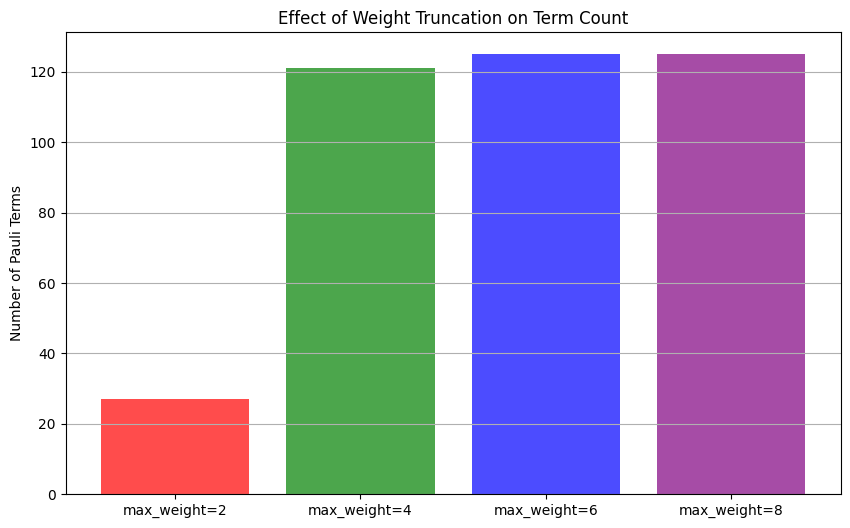

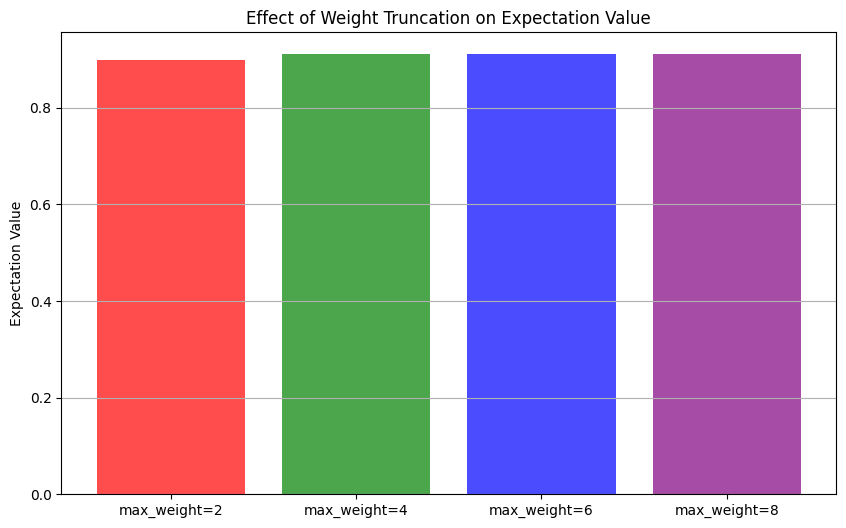

In [9]:
# Let's examine how the number of terms grows with different truncation settings
trunc_settings = [
    {"max_weight": 2, "min_abs_coeff": 1e-4, "color": "red", "label": "max_weight=2"},
    {"max_weight": 4, "min_abs_coeff": 1e-4, "color": "green", "label": "max_weight=4"},
    {"max_weight": 6, "min_abs_coeff": 1e-4, "color": "blue", "label": "max_weight=6"},
    {"max_weight": 8, "min_abs_coeff": 1e-4, "color": "purple", "label": "max_weight=8"}
]

results_trunc_comparison = []
for setting in trunc_settings:
    result = pp.propagate(
        circuit, observable_sum, parameters_numpy,
        max_weight=setting["max_weight"],
        min_abs_coeff=setting["min_abs_coeff"]
    )
    results_trunc_comparison.append({
        "setting": setting,
        "num_terms": len(result),
        "overlap": pp.overlapwithzero(result)
    })
    print(f"{setting['label']}: {results_trunc_comparison[-1]['num_terms']} terms, overlap = {results_trunc_comparison[-1]['overlap']:.6f}")

plt.figure(figsize=(10, 6))
for res_item in results_trunc_comparison:
    setting = res_item["setting"]
    plt.bar(setting["label"], res_item["num_terms"], color=setting["color"], alpha=0.7)
plt.ylabel("Number of Pauli Terms")
plt.title("Effect of Weight Truncation on Term Count")
plt.grid(True, axis="y")
plt.show()

plt.figure(figsize=(10, 6))
for res_item in results_trunc_comparison:
    setting = res_item["setting"]
    plt.bar(setting["label"], res_item["overlap"], color=setting["color"], alpha=0.7)
plt.ylabel("Expectation Value")
plt.title("Effect of Weight Truncation on Expectation Value")
plt.grid(True, axis="y")
plt.show()

## Working with Data Between Python and Julia.

A key aspect of using `juliacall` is understanding how data converts between Python and Julia. The good news is `juliacall` handles a lot of this automatically!

1.  **Julia arrays to NumPy arrays**: When a Julia function returns an array, `juliacall` often gives you an object that behaves like a NumPy array (or can be easily converted with `np.array()`).
2.  **NumPy arrays to Julia arrays**: As we've seen, passing a NumPy array to a Julia function that expects an array usually just works.
3.  **Working with Julia objects in Python**: You get back Python-side representations of Julia objects. For many common types (numbers, strings, collections), these behave very intuitively. For example, `len()` works on Julia collections.
4.  **Accessing Julia documentation from Python**: You can still use `jl.seval("@doc ...")`.

In [ ]:
# Julia function returning an array
julia_random_array = jl.rand(5)
print("Julia array (via juliacall):", julia_random_array)
print("Type of Julia array object in Python:", type(julia_random_array))

# Converting to NumPy array
numpy_array_from_julia = np.array(julia_random_array)
print("NumPy array type:", type(numpy_array_from_julia))
print("NumPy array content:", numpy_array_from_julia)

# Creating a NumPy array and passing it to a Julia function that uses it
jl.seval("""
function sum_julia_array(arr)
    return sum(arr)
end
""")
my_numpy_array = np.array([1.0, 2.0, 3.0, 4.0])
sum_from_julia = jl.sum_julia_array(my_numpy_array) 
print(f"Sum from Julia (passing NumPy array {my_numpy_array}): {sum_from_julia} (type: {type(sum_from_julia)})")


# Using len() on the pauli_sum_result from a previous cell
print(f"Number of Pauli terms in our main result (using Python's len()): {len(pauli_sum_result)}")

# Accessing documentation
help_text = jl.seval("@doc PauliPropagation.propagate")
print("\nDocumentation for propagate function (first 10 lines):")
help_text_str = str(jl.string(help_text))
print("\n".join(help_text_str.split("\n")[:10]) + "\n...")

Julia array (via juliacall): [0.23557405941361165, 0.5461332321856088, 0.493810316490061, 0.1361828572101027, 0.682299220384086]
Type of Julia array object in Python: <class 'juliacall.VectorValue'>
NumPy array type: <class 'numpy.ndarray'>
NumPy array content: [0.23557406 0.54613323 0.49381032 0.13618286 0.68229922]
Sum from Julia (passing NumPy array [1. 2. 3. 4.]): 10.0 (type: <class 'float'>)
Number of Pauli terms in our main result (using Python's len()): 125

Documentation for propagate function (first 10 lines):
```
propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)
```

Propagate a `PauliString` through the circuit `circ` in the Heisenberg picture.  This means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action. Parameters for the parametrized gates in `circ` are given by `thetas`, and need to be passed as if the 

## Efficient Layer-wise Evolution:

Now we'll demonstrate a more sophisticated and efficient approach to quantum simulation: layer-wise evolution.

Instead of creating a circuit with multiple layers and propagating through it once, we:

1. Create a single-layer circuit.
2. Repeatedly propagate our observable (PauliSum) through this single layer.
3. Track the expectation value and term count after each layer.

This approach is:
- More computationally efficient for deep circuits as the PauliSum object is updated iteratively.
- Closer to how real quantum systems evolve in discrete time steps.
- Gives us insight into the dynamics of the system as it evolves.

We'll continue to use Pythonic coding style, relying on `juliacall` for conversions.

Let's watch the evolution layer by layer...
Layer 0, Overlap: 1.0000, Terms: 1
Layer 1, Overlap: 0.9950, Terms: 12
Layer 5, Overlap: 0.9109, Terms: 125
Layer 10, Overlap: 0.8647, Terms: 839
Layer 15, Overlap: 0.9101, Terms: 3421
Layer 20, Overlap: 0.9113, Terms: 8751


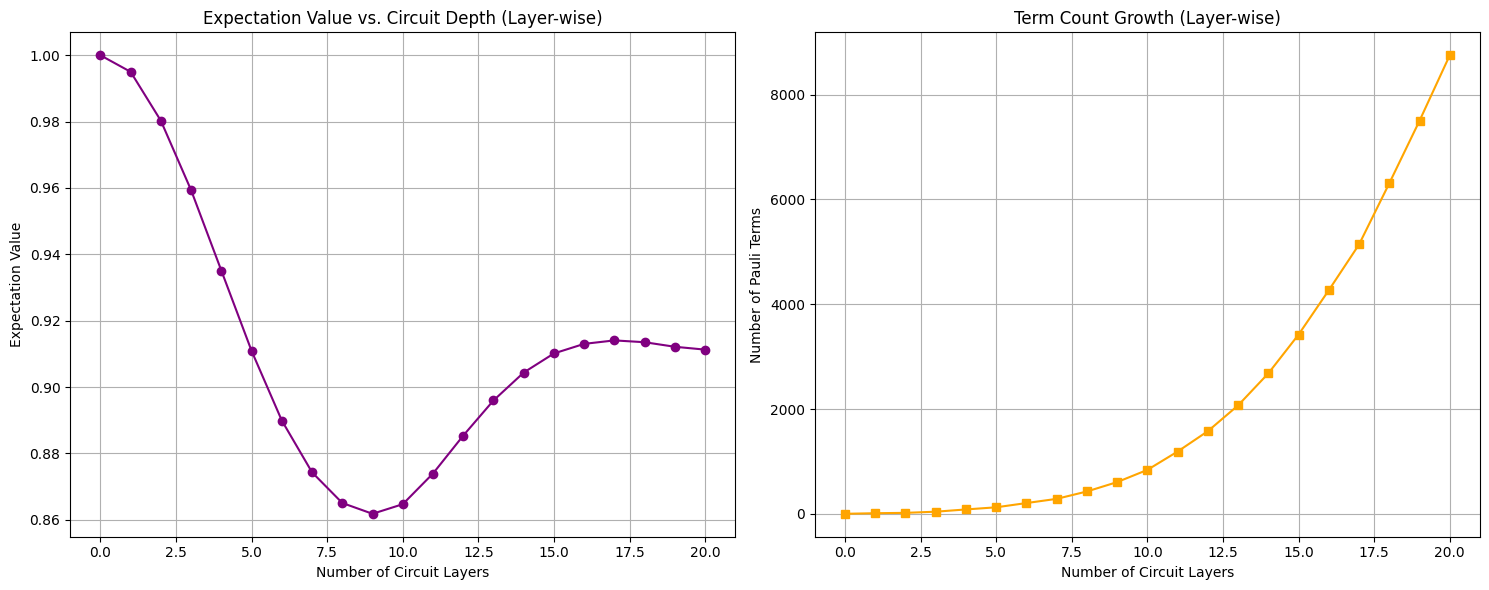

In [11]:
print("Let's watch the evolution layer by layer...")

max_layers = 20
dt_layer = 0.1

single_layer_circuit = pp.tiltedtfitrottercircuit(nqubits, 1, topology=custom_connections_py)
num_single_layer_params = pp.countparameters(single_layer_circuit)
numpy_single_layer_params = np.full(num_single_layer_params, dt_layer)

current_psum = pp.PauliSum(pp.PauliString(nqubits, Zsym, nqubits // 2))


layer_indices = list(range(0, max_layers + 1))
expectation_values_layerwise = [pp.overlapwithzero(current_psum)]
term_counts_layerwise = [len(current_psum)]
print(f"Layer 0, Overlap: {expectation_values_layerwise[0]:.4f}, Terms: {term_counts_layerwise[0]}")

for layer in range(1, max_layers + 1):
    current_psum = pp.propagate(
        single_layer_circuit, current_psum, numpy_single_layer_params,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )

    current_overlap = pp.overlapwithzero(current_psum)
    current_terms = len(current_psum)
    expectation_values_layerwise.append(current_overlap)
    term_counts_layerwise.append(current_terms)

    if layer % 5 == 0 or layer == 1 or layer == max_layers:
        print(f"Layer {layer}, Overlap: {current_overlap:.4f}, Terms: {current_terms}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(layer_indices, expectation_values_layerwise, 'o-', color='purple')
ax1.set_xlabel('Number of Circuit Layers')
ax1.set_ylabel('Expectation Value')
ax1.set_title('Expectation Value vs. Circuit Depth (Layer-wise)')
ax1.grid(True)

ax2.plot(layer_indices, term_counts_layerwise, 's-', color='orange')
ax2.set_xlabel('Number of Circuit Layers')
ax2.set_ylabel('Number of Pauli Terms')
ax2.set_title('Term Count Growth (Layer-wise)')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Comparing Truncation Effects (Layer-wise):

One of the most important considerations when using Pauli propagation is choosing appropriate truncation parameters. Let's systematically compare different truncation settings for the layer-wise evolution and visualize their effects.

We'll compare:
- Different `max_weight` settings (2, 4, 6, 8)
- Same `min_abs_coeff` setting (1e-4)

This will help us understand the trade-off between accuracy and computational cost during the step-by-step evolution.

Max weight 2: 71 Pauli terms after 20 layers
Max weight 4: 2267 Pauli terms after 20 layers
Max weight 6: 8751 Pauli terms after 20 layers
Max weight 8: 10530 Pauli terms after 20 layers


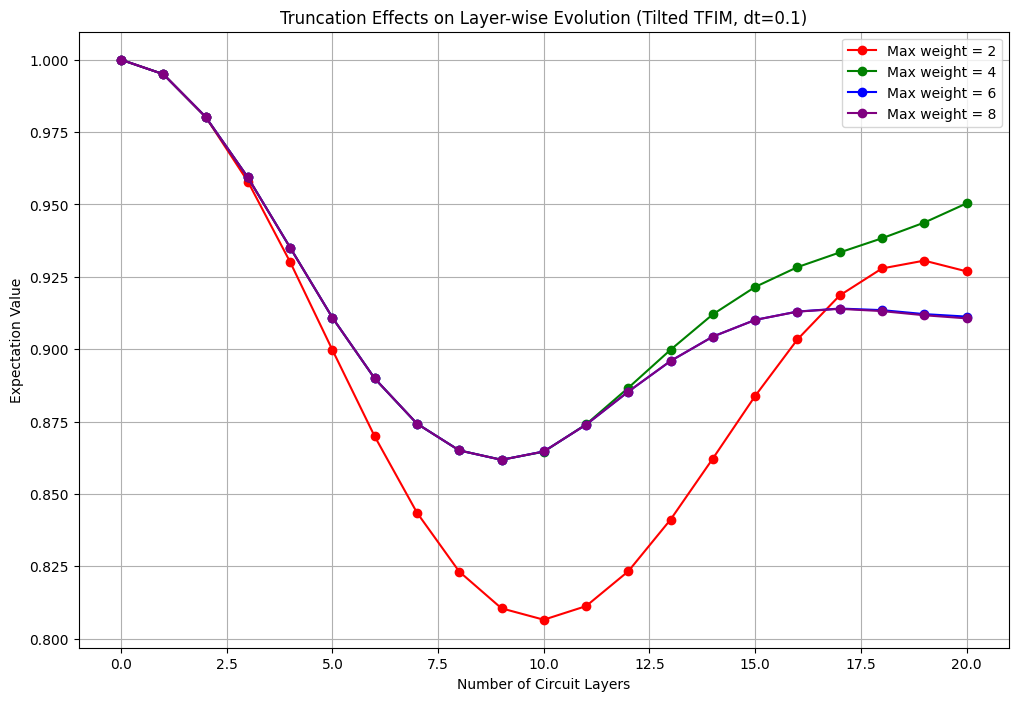

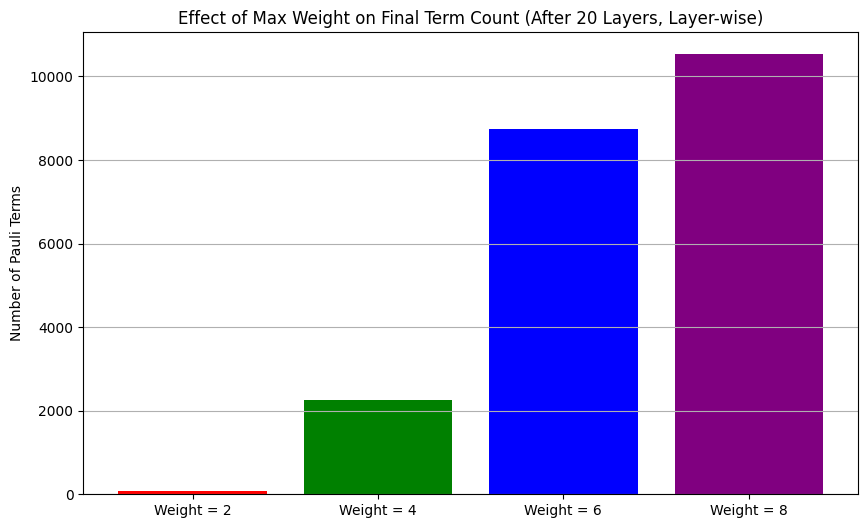

In [14]:
weight_settings_comparison = [2, 4, 6, 8]
colors_comparison = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

final_term_counts_comparison = []

initial_pauli_string_for_comparison = pp.PauliString(nqubits, Zsym, nqubits // 2)

for idx, current_max_w_comp in enumerate(weight_settings_comparison):
    psum_trunc_comp = pp.PauliSum(initial_pauli_string_for_comparison)

    expectation_values_trunc_comp = [pp.overlapwithzero(psum_trunc_comp)]
    for layer_comp in range(1, max_layers + 1):
        psum_trunc_comp = pp.propagate(
            single_layer_circuit, psum_trunc_comp, numpy_single_layer_params,
            max_weight=current_max_w_comp,
            min_abs_coeff=min_abs_coeff
        )
        expectation_values_trunc_comp.append(pp.overlapwithzero(psum_trunc_comp))

    term_count_comp = len(psum_trunc_comp)
    final_term_counts_comparison.append(term_count_comp)
    print(f"Max weight {current_max_w_comp}: {term_count_comp} Pauli terms after {max_layers} layers")

    plt.plot(layer_indices, expectation_values_trunc_comp, 'o-', color=colors_comparison[idx],
             label=f'Max weight = {current_max_w_comp}')

plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Truncation Effects on Layer-wise Evolution (Tilted TFIM, dt={dt_layer})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for idx, (weight_comp, count_comp) in enumerate(zip(weight_settings_comparison, final_term_counts_comparison)):
    plt.bar(f"Weight = {weight_comp}", count_comp, color=colors_comparison[idx])
plt.ylabel('Number of Pauli Terms')
plt.title(f'Effect of Max Weight on Final Term Count (After {max_layers} Layers, Layer-wise)')
plt.grid(True, axis='y')
plt.show()

## Common Limitations and Considerations

While this approach works well, there are some limitations worth noting:

- There's some overhead going back and forth between Python and Julia - not huge, but noticeable
- Memory usage can spike when dealing with many Pauli terms - this requires monitoring
- Error messages can be confusing - they often don't clearly indicate which side (Python or Julia) had the issue

This approach works best when:
- The observable doesn't spread out too much during evolution
- Working with systems too large for direct state vector methods
- Only specific observables are needed, rather than the whole quantum state

Users of this approach should become familiar with:
- Basic Julia type system concepts (enough to understand error messages)
- The fundamentals of the Heisenberg picture for evolution
- Strategies for balancing truncation parameters for specific problems

## Summary and Next Steps

In this notebook, we've demonstrated how to use `PauliPropagation.jl` from Python using `juliacall`. We've covered:

- Setting up the Julia-Python bridge
- Creating Pauli operators and quantum circuits
- Converting between Python and Julia data structures
- Implementing efficient layer-wise evolution
- Understanding and comparing truncation effects

### Further Exploration Ideas
- Try different circuit architectures and observables
- Benchmark against other quantum simulation methods
- Implement custom circuit designs using Python data structures
- Study how different observables evolve through the same circuit
- Explore more advanced truncation strategies

For more information, you can refer to the documentation of PauliPropagation.jl and JuliaCall.